# Annexin Late Apoptotic-vs-T2

**Regression analysis of Annexin % Late Apoptotic cells and proliferation inflection points.**

In [1]:
import numpy as np
import scipy.optimize as optim
import math
import os,sys
import pandas as pd
import copy
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scipy.stats as st
from scipy.stats import t

from sklearn.metrics import auc

In [2]:
def linear(x,a,b):
    return (a + b*x)

In [3]:
data_folder = './data/Annexin'
os.chdir(data_folder)

**Read Annexin data**

In [4]:
v24 = pd.read_csv('all-Annexin24h-data.csv')

name_tag = {}

name_tag['AH'] = 'Healthy cells (%)'
name_tag['AEA'] = 'Early apoptotic cells (%)'
name_tag['ALA'] = 'Late apoptotic cells (%)'
name_tag['AN'] = 'Necrotic cells (%)'

experiment_name = v24['Experiment name'].dropna().to_list()

In [5]:
weight1 = pd.Series([0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9])
colors1 = weight1.apply(lambda x: (0,0,0,x)).tolist()

In [6]:
all_data = {}

for n in list(v24):
    all_data[n] = v24[n].to_numpy()

all_data['T2'] = 85.77*np.power(all_data['AODAPI']/100,-1.7)

In [7]:
tag = 'ALA'

result = st.linregress(all_data[tag],all_data['T2'],alternative='two-sided')

r_text = r'$\mathrm{R}^2 = ' + str(round(result.rvalue**2,3)) + '$'

In [8]:
results = optim.curve_fit(linear,all_data[tag],all_data['T2'],absolute_sigma=False,full_output=True)

popt, pcov = results[0], results[1]

p_std = np.sqrt(np.diag(pcov))

fitname = r'T2$_{\mathrm{est}}$ = ' + str(round(popt[0],2)) + ' + ' + str(round(abs(popt[1]),2)) + tag

In [9]:
dof = len(all_data['T2']) - 2
    
tinv = lambda p, df: abs(t.ppf(p/2,df))
ts = tinv(0.05,dof)

s_err = ts*result.stderr
i_err = ts*result.intercept_stderr

In [10]:
residual = linear(all_data[tag],popt[0],popt[1]) - all_data['T2']
norm_RSS = math.sqrt(np.dot(residual,residual)/(len(all_data['T2'])-2))
RSS_text = r's.d. = ' + str(round(norm_RSS,2)) + ' h'

In [11]:
d = all_data[tag]
mean_x = np.linspace(0.8*np.min(d),1.2*np.max(d),100)
mean_t2 = linear(mean_x,popt[0],popt[1])

**Compute confidence interval and prediction bound.**

In [12]:
n_samples = 10000

s_is, i_is = [], []

cit2_up = np.zeros(shape=mean_x.shape)
cit2_low = np.zeros(shape=mean_x.shape)

pbt2_up = np.zeros(shape=mean_x.shape)
pbt2_low = np.zeros(shape=mean_x.shape)

sigmat2_up = np.zeros(shape=mean_x.shape)
sigmat2_low = np.zeros(shape=mean_x.shape)

t2 = np.zeros(shape=mean_x.shape)
effective_sigma = np.zeros(shape=mean_x.shape)

for i in range(0,mean_x.shape[0]):
    samples = []
    
    a_samples, b_samples = np.random.multivariate_normal(popt,pcov,n_samples).T
        
    for a_sample,b_sample in zip(a_samples,b_samples):
        samples.append(linear(mean_x[i],a_sample,b_sample))
        
    t2[i] = linear(mean_x[i],popt[0],popt[1])
        
    sigma = np.std(samples)
    
    effective_sigma[i] = math.sqrt(sigma**2 + norm_RSS**2)
    
    ci95 = effective_sigma[i]*ts
        
    pbt2_low[i], pbt2_up[i] = mean_t2[i] - ci95, mean_t2[i] + ci95
    
    cit2_low[i], cit2_up[i] = mean_t2[i] - sigma*ts, mean_t2[i] + sigma*ts
    
    sigmat2_low[i], sigmat2_up[i] = mean_t2[i] - effective_sigma[i], mean_t2[i] + effective_sigma[i]

In [13]:
# Number of points in each set
n = 7

Text(2, 255, 'T2$_{\\mathrm{est}}$ = 77.0 + 1.87ALA')

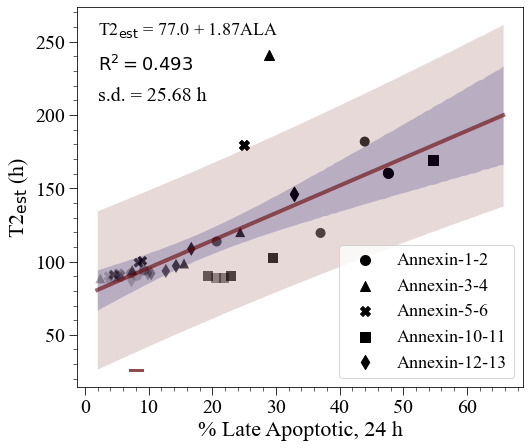

In [14]:
fig, axs = plt.subplots(figsize=(8,7))

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Times New Roman']

plt.scatter(all_data[tag][:n],all_data['T2'][:n],marker='o',linewidth=0,s=100,c=colors1)
plt.scatter(all_data[tag][n:2*n],all_data['T2'][n:2*n],marker='^',linewidth=0,s=100,c=colors1)
plt.scatter(all_data[tag][2*n:3*n],all_data['T2'][2*n:3*n],marker='X',linewidth=0,s=100,c=colors1)
plt.scatter(all_data[tag][3*n:4*n],all_data['T2'][3*n:4*n],marker='s',linewidth=0,s=100,c=colors1)
plt.scatter(all_data[tag][4*n:],all_data['T2'][4*n:],marker='d',linewidth=0,s=100,c=colors1)

plt.scatter(all_data[tag][n-1],all_data['T2'][n-1],marker='o',s=100,c='black',label=experiment_name[0])
plt.scatter(all_data[tag][2*n-1],all_data['T2'][2*n-1],marker='^',s=100,c='black',label=experiment_name[1])
plt.scatter(all_data[tag][3*n-1],all_data['T2'][3*n-1],marker='X',s=100,c='black',label=experiment_name[2])
plt.scatter(all_data[tag][4*n-1],all_data['T2'][4*n-1],marker='s',s=100,c='black',label=experiment_name[3])
plt.scatter(all_data[tag][-1],all_data['T2'][-1],marker='d',s=100,c='black',label=experiment_name[4])

plt.plot(mean_x,mean_t2,alpha=0.6,lw=4,color='#660000')
plt.fill_between(mean_x,pbt2_up,pbt2_low,alpha=0.15,color='#660000',linewidth=0.0)
plt.fill_between(mean_x,cit2_up,cit2_low,alpha=0.2,color='#000066',linewidth=0.0)

plt.xticks(size=20)
plt.yticks(size=20)  
plt.xlabel('% Late Apoptotic, 24 h',size=22)
plt.ylabel(r'T2$_{\mathrm{est}}$ (h)',size=22,rotation=90)
plt.minorticks_on()
axs.tick_params(which='major', length=8)
axs.tick_params(which='minor', length=4)
plt.legend(frameon=True,prop={'size': 18},markerscale=1.0,handlelength=2.0,loc='lower right')
plt.text(2,230,r_text,fontsize=18)
plt.text(2,210,RSS_text,fontsize=20)

plt.plot(np.linspace(7,9,2),26*np.ones(2,),color='#660000',alpha=0.7,lw=3)
plt.text(2,255,fitname,fontsize=18)

**Compute survival function and conditional viability distribution.**

In [15]:
#test_t2s = [96,108,120,132,144,156,168,180,192,204,216,228,240,252,264]
test_t2s = [96,120,144,168,192,216,240,264]
#test_t2s = [96,144,192,240]
test_t2s.reverse()

cutoff_probs = {}
pdfs = {}
cdfs = {}

for k in test_t2s:
    cutoff_probs[k] = np.zeros(shape=mean_x.shape)
    pdfs[k] = np.zeros(shape=mean_x.shape)
    
responses = np.zeros(shape=(len(test_t2s),mean_x.shape[0]))

j = 0

for k in test_t2s:
    for i in range(0,mean_x.shape[0]):
        cutoff_probs[k][i] = st.t.sf(k,df=dof,loc=t2[i],scale=effective_sigma[i])
        pdfs[k][i] = st.t.pdf(k,df=dof,loc=t2[i],scale=effective_sigma[i])
        
    pdfs[k] *= 1.0/np.sum(pdfs[k])
    
    x = copy.deepcopy(pdfs[k])#[::-1])
    cdfs[k] = np.round(np.array([np.sum(x[m:]) for m in range(0,pdfs[k].shape[0])] + [0]),3)
    
    responses[j,:] = pdfs[k]
    
    j += 1

Text(0.5, 0, '% Late Apoptotic, 24 h')

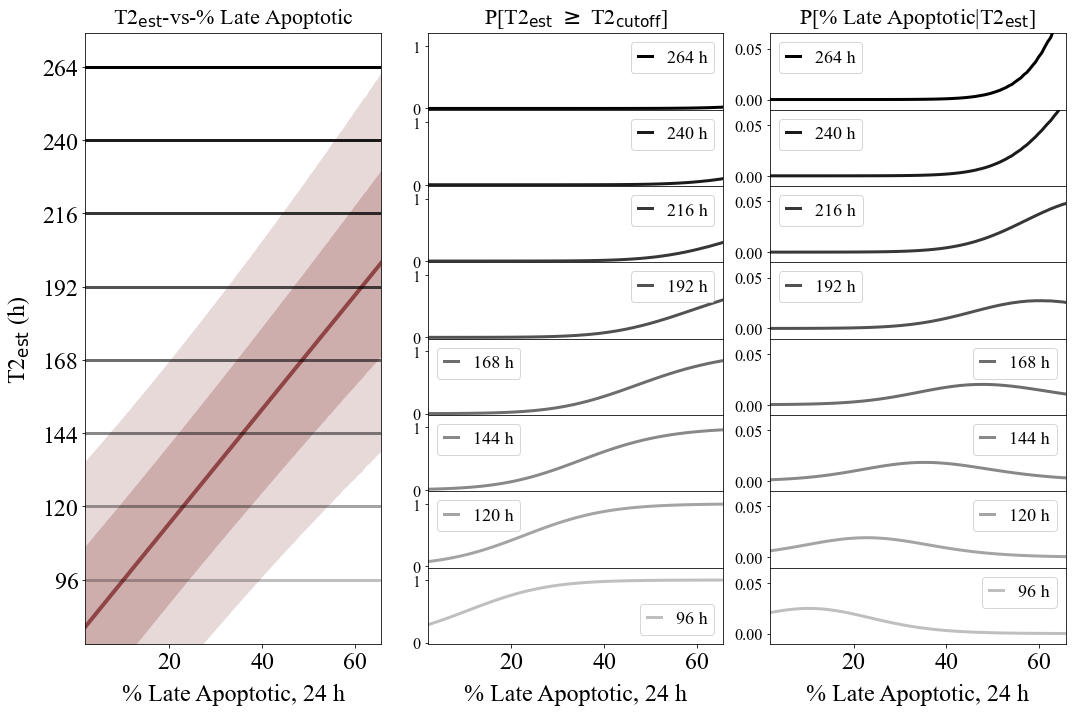

In [16]:
fig = plt.figure(tight_layout=True,figsize=(15,10))
gs = fig.add_gridspec(len(test_t2s),3, hspace=0)

ax = fig.add_subplot(gs[:,0])
ax.plot(mean_x,t2,linewidth=4,color='#660000',alpha=0.6,label=fitname)
ax.fill_between(mean_x,pbt2_up,pbt2_low,alpha=0.15,color='#660000',linewidth=0.0)
ax.fill_between(mean_x,sigmat2_up,sigmat2_low,alpha=0.2,color='#660000',linewidth=0.0)

ax.set_title(r'T2$_{\mathrm{est}}$-vs-% Late Apoptotic',size=22,pad=10)

ax.tick_params(axis='both',labelsize=24)
ax.set_yticks(test_t2s)
ax.set_xlabel(r'% Late Apoptotic, 24 h',size=24,labelpad=10)
ax.set_ylabel(r'T2$_{\mathrm{est}}$ (h)',size=24,rotation=90,labelpad=10)
ax.set_ylim(75,275)
ax.set_xlim(np.min(mean_x),np.max(mean_x))

for t in test_t2s:
    _alpha = 0.25 + 0.75*(t - np.min(test_t2s))/(np.max(test_t2s) - np.min(test_t2s))
    
    ax.plot(mean_x,t*np.ones(shape=mean_x.shape[0]),color='black',lw=3,alpha=_alpha)

for k in range(len(test_t2s)):
    ax = fig.add_subplot(gs[k,1])
    
    _alpha = 0.25 + 0.75*(test_t2s[k] - np.min(test_t2s))/(np.max(test_t2s) - np.min(test_t2s))
    
    ax.plot(mean_x,cutoff_probs[test_t2s[k]],lw=3,color='black',label=str(test_t2s[k])+' h',alpha=_alpha)
    ax.tick_params(axis='y',labelsize=12)
    ax.set_ylim(-0.02,1.2)
    ax.set_xlim(np.min(mean_x),np.max(mean_x))
    ax.legend(frameon=True,prop={'size': 18,'family':'Times New Roman'},markerscale=1.0,handlelength=0.8,loc='best')

    ax.tick_params(axis='y',labelsize=16)
    
    if k==len(test_t2s)-1:
        ax.tick_params(axis='x',labelsize=24)
    else:
        ax.tick_params(axis='x',labelsize=0)
        
    if k==0:
        ax.set_title(r'P[T2$_{\mathrm{est}}$ $\geq$ T2$_{\mathrm{cutoff}}$]',size=22,pad=10)
        
ax.set_xlabel(r'% Late Apoptotic, 24 h',size=24,labelpad=10)
        
for k in range(len(test_t2s)):
    ax = fig.add_subplot(gs[k,2])
    
    _alpha = 0.25 + 0.75*(test_t2s[k] - np.min(test_t2s))/(np.max(test_t2s) - np.min(test_t2s))
    
    ax.plot(mean_x,pdfs[test_t2s[k]],lw=3,color='black',label=str(test_t2s[k])+' h',alpha=_alpha)
    ax.tick_params(axis='y',labelsize=12)
    ax.set_xlim(np.min(mean_x),np.max(mean_x))
    ax.legend(frameon=True,prop={'size': 18,'family':'Times New Roman'},markerscale=1.0,handlelength=0.8,loc='best')

    ax.set_ylim(-0.01,0.065)
    
    ax.tick_params(axis='y',labelsize=16)
    
    if k==len(test_t2s)-1:
        ax.tick_params(axis='x',labelsize=24)
    else:
        ax.tick_params(axis='x',labelsize=0)
        
    if k==0:
        ax.set_title('P[% Late Apoptotic|T2$_{\mathrm{est}}$]',size=22,pad=10)
          
ax.set_xlabel(r'% Late Apoptotic, 24 h',size=24,labelpad=10)

**Compute AUC values.**

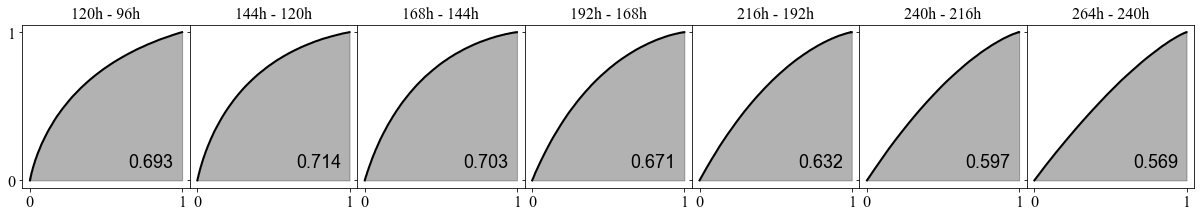

In [17]:
wd = 3

l = int((len(test_t2s)-1)*wd)

fig = plt.figure(figsize=(l,wd))
gs = fig.add_gridspec(ncols=len(test_t2s)-1, nrows=1, wspace=0)

axs = gs.subplots(sharex=True,sharey=True)

all_aucs = []

test_t2s = test_t2s[::-1]

wf = open('auc_summary.csv','w')
print('Time interval,AUC',file=wf)

for k in range(0,len(test_t2s)-1):
    dx = copy.deepcopy(cdfs[test_t2s[k]][::-1])
    dy = copy.deepcopy(cdfs[test_t2s[k+1]][::-1])
    
    all_aucs.append(auc(dx,dy))
    
    label_text = str(round(all_aucs[-1],3))
    
    axs[k].plot(dx,dy,lw=2,color='black',label=label_text)
    axs[k].fill_between(dx,0,dy,color='black',alpha=0.3)#,label=str(test_t2s[k])+' h',alpha=_alpha)
    axs[k].set_xticks((0,1))
    axs[k].set_yticks((0,1))
    axs[k].tick_params(axis='both',labelsize=16)
    axs[k].legend(frameon=False,prop={'size': 18,'family':'Arial'},markerscale=1.0,handlelength=0.0,loc='lower right')
    axs[k].set_title(str(test_t2s[k+1])+'h - '+str(test_t2s[k])+'h',fontsize=16)
    
    output_string = str(test_t2s[k])+'h - '+str(test_t2s[k+1])+'h'
    output_string += ',' + label_text
    
    print(output_string,file=wf)
    
wf.close()